In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

import matplotlib

#import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
#import xarray as xr
from joblib import dump, load
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.preprocessing import QuantileTransformer

warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 300
from sklearn.feature_selection import RFE

In [8]:
# labels dictionary
with open('../../../var_labels.json', "r") as fp:
    # Load the dictionary from the file
    labels_dict = json.load(fp)

In [10]:
def PFI(X,y,model):
    # permutation feature importance
    feature_names = list(X.columns)
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    # sort importances
    sort_idx = result.importances_mean.argsort()
    importances_mean = result.importances_mean[sort_idx]
    importances_std = result.importances_std[sort_idx]
    feature_names = np.array(feature_names)[sort_idx]
    forest_importances = pd.Series(importances_mean, index=feature_names)
    top_feat = feature_names[::-1][:20]
    return top_feat

# data

In [13]:
#load data
X_train = pd.read_csv("xtrain.csv", index_col=0)
y_train = pd.read_csv("ytrain.csv", index_col=0)
X_test = pd.read_csv("xtest.csv", index_col=0)
y_test = pd.read_csv("ytest.csv", index_col=0)
groups = X_train['groups']
X_train = X_train.drop(columns='groups')
feature_names = list(X_train.columns)

In [15]:
#load model
model_day = load('forest.joblib')
best_model = model_day.best_estimator_

In [16]:
best_model = best_model.set_params(regressor__n_jobs=-2)

# REE

In [20]:
# ree list
REE_FI = pd.read_csv('REE_FI.csv', index_col=0)
ree_feat = REE_FI.index[::-1]

best_model.fit(X_train[ree_feat],y_train)
print("Score: {:3.2f}".format(best_model.score(X_test[ree_feat],y_test)))

Score: 0.89


# VIF

In [22]:
X=X_train

In [23]:
df_cor = X.corr()
df_vif = pd.DataFrame(np.linalg.inv(df_cor.values), index = df_cor.index, columns=df_cor.columns)
vif = pd.Series(np.diag(df_vif), index=df_vif.index).sort_values()

In [24]:
while vif[-1]>5:
    if vif[0]<0:
        worst=vif.index[0]
    else:
        worst=vif.index[-1]
    X=X.drop(columns=worst)
    df_cor = X.corr()
    df_vif = pd.DataFrame(np.linalg.inv(df_cor.values), index = df_cor.index, columns=df_cor.columns)
    vif = pd.Series(np.diag(df_vif), index=df_vif.index).sort_values()

selected_features_names = vif.index

In [25]:
%%time
best_model.fit(X_train[selected_features_names],y_train)

print("Score: {:3.2f}".format(best_model.score(X_test[selected_features_names],y_test)))

vif_feat = PFI(X_train[selected_features_names],y_train,best_model)

Score: 0.91
CPU times: total: 1min 35s
Wall time: 52.7 s


# Forward selection

In [27]:
forest_FI = pd.read_csv('forest_FI.csv', index_col=0).iloc[-30:]

In [28]:
top_feat = [forest_FI.iloc[-1].name]
forest_FI.drop(index=top_feat)
R2 = best_model.fit(X_train[top_feat],y_train).score(X_test[top_feat],y_test)

In [30]:
from tqdm import tqdm

for i in tqdm(range(10)):
    try_feat = forest_FI[-15:].index
    R2=[]
    for feat in try_feat:
        R2.append(best_model.fit(X_train[top_feat+[feat]],y_train).score(X_test[top_feat+[feat]],y_test))
    best_feat = try_feat[np.argmax(R2)]
    top_feat.append(best_feat)
    forest_FI.drop(index=best_feat)

100%|██████████| 10/10 [05:07<00:00, 30.72s/it]


In [31]:
np.max(R2)

0.8958329212677723

In [33]:
top_feat

['zeta_blh',
 'uT_wT',
 'rapid_dist',
 'z_zi',
 'uv_tke',
 'Ra',
 'U_wfc',
 'Ri',
 'Ra',
 'Ra',
 'uv_tke']

In [35]:
best_model.fit(X_train[top_feat],y_train)
print("Score: {:3.2f}".format(best_model.score(X_test[top_feat],y_test)))
fws_feat = PFI(X_train[top_feat],y_train,best_model)

Score: 0.90


# RFE

In [38]:
# apply scaler separately
X_scaled = QuantileTransformer().fit_transform(X_train)
y_scaled = QuantileTransformer().fit_transform(y_train)

# RFE
rfe = RFE(best_model[-1], n_features_to_select=10, step=2).fit(X_scaled,y_scaled)
rfe_feat = X_train.columns[rfe.support_]


In [39]:
best_model.fit(X_train[rfe_feat],y_train)
print("Score: {:3.2f}".format(best_model.score(X_test[rfe_feat],y_test)))
rfe_feat = PFI(X_train[rfe_feat],y_train,best_model)

Score: 0.89


In [40]:
fws_feat[:6]

array(['rapid_dist', 'zeta_blh', 'z_zi', 'U_wfc', 'uT_wT', 'uv_tke'],
      dtype='<U10')

# compare

In [42]:
color_list = [ '#0a706b', '#f9f6f1', '#a51f12']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('name',color_list)

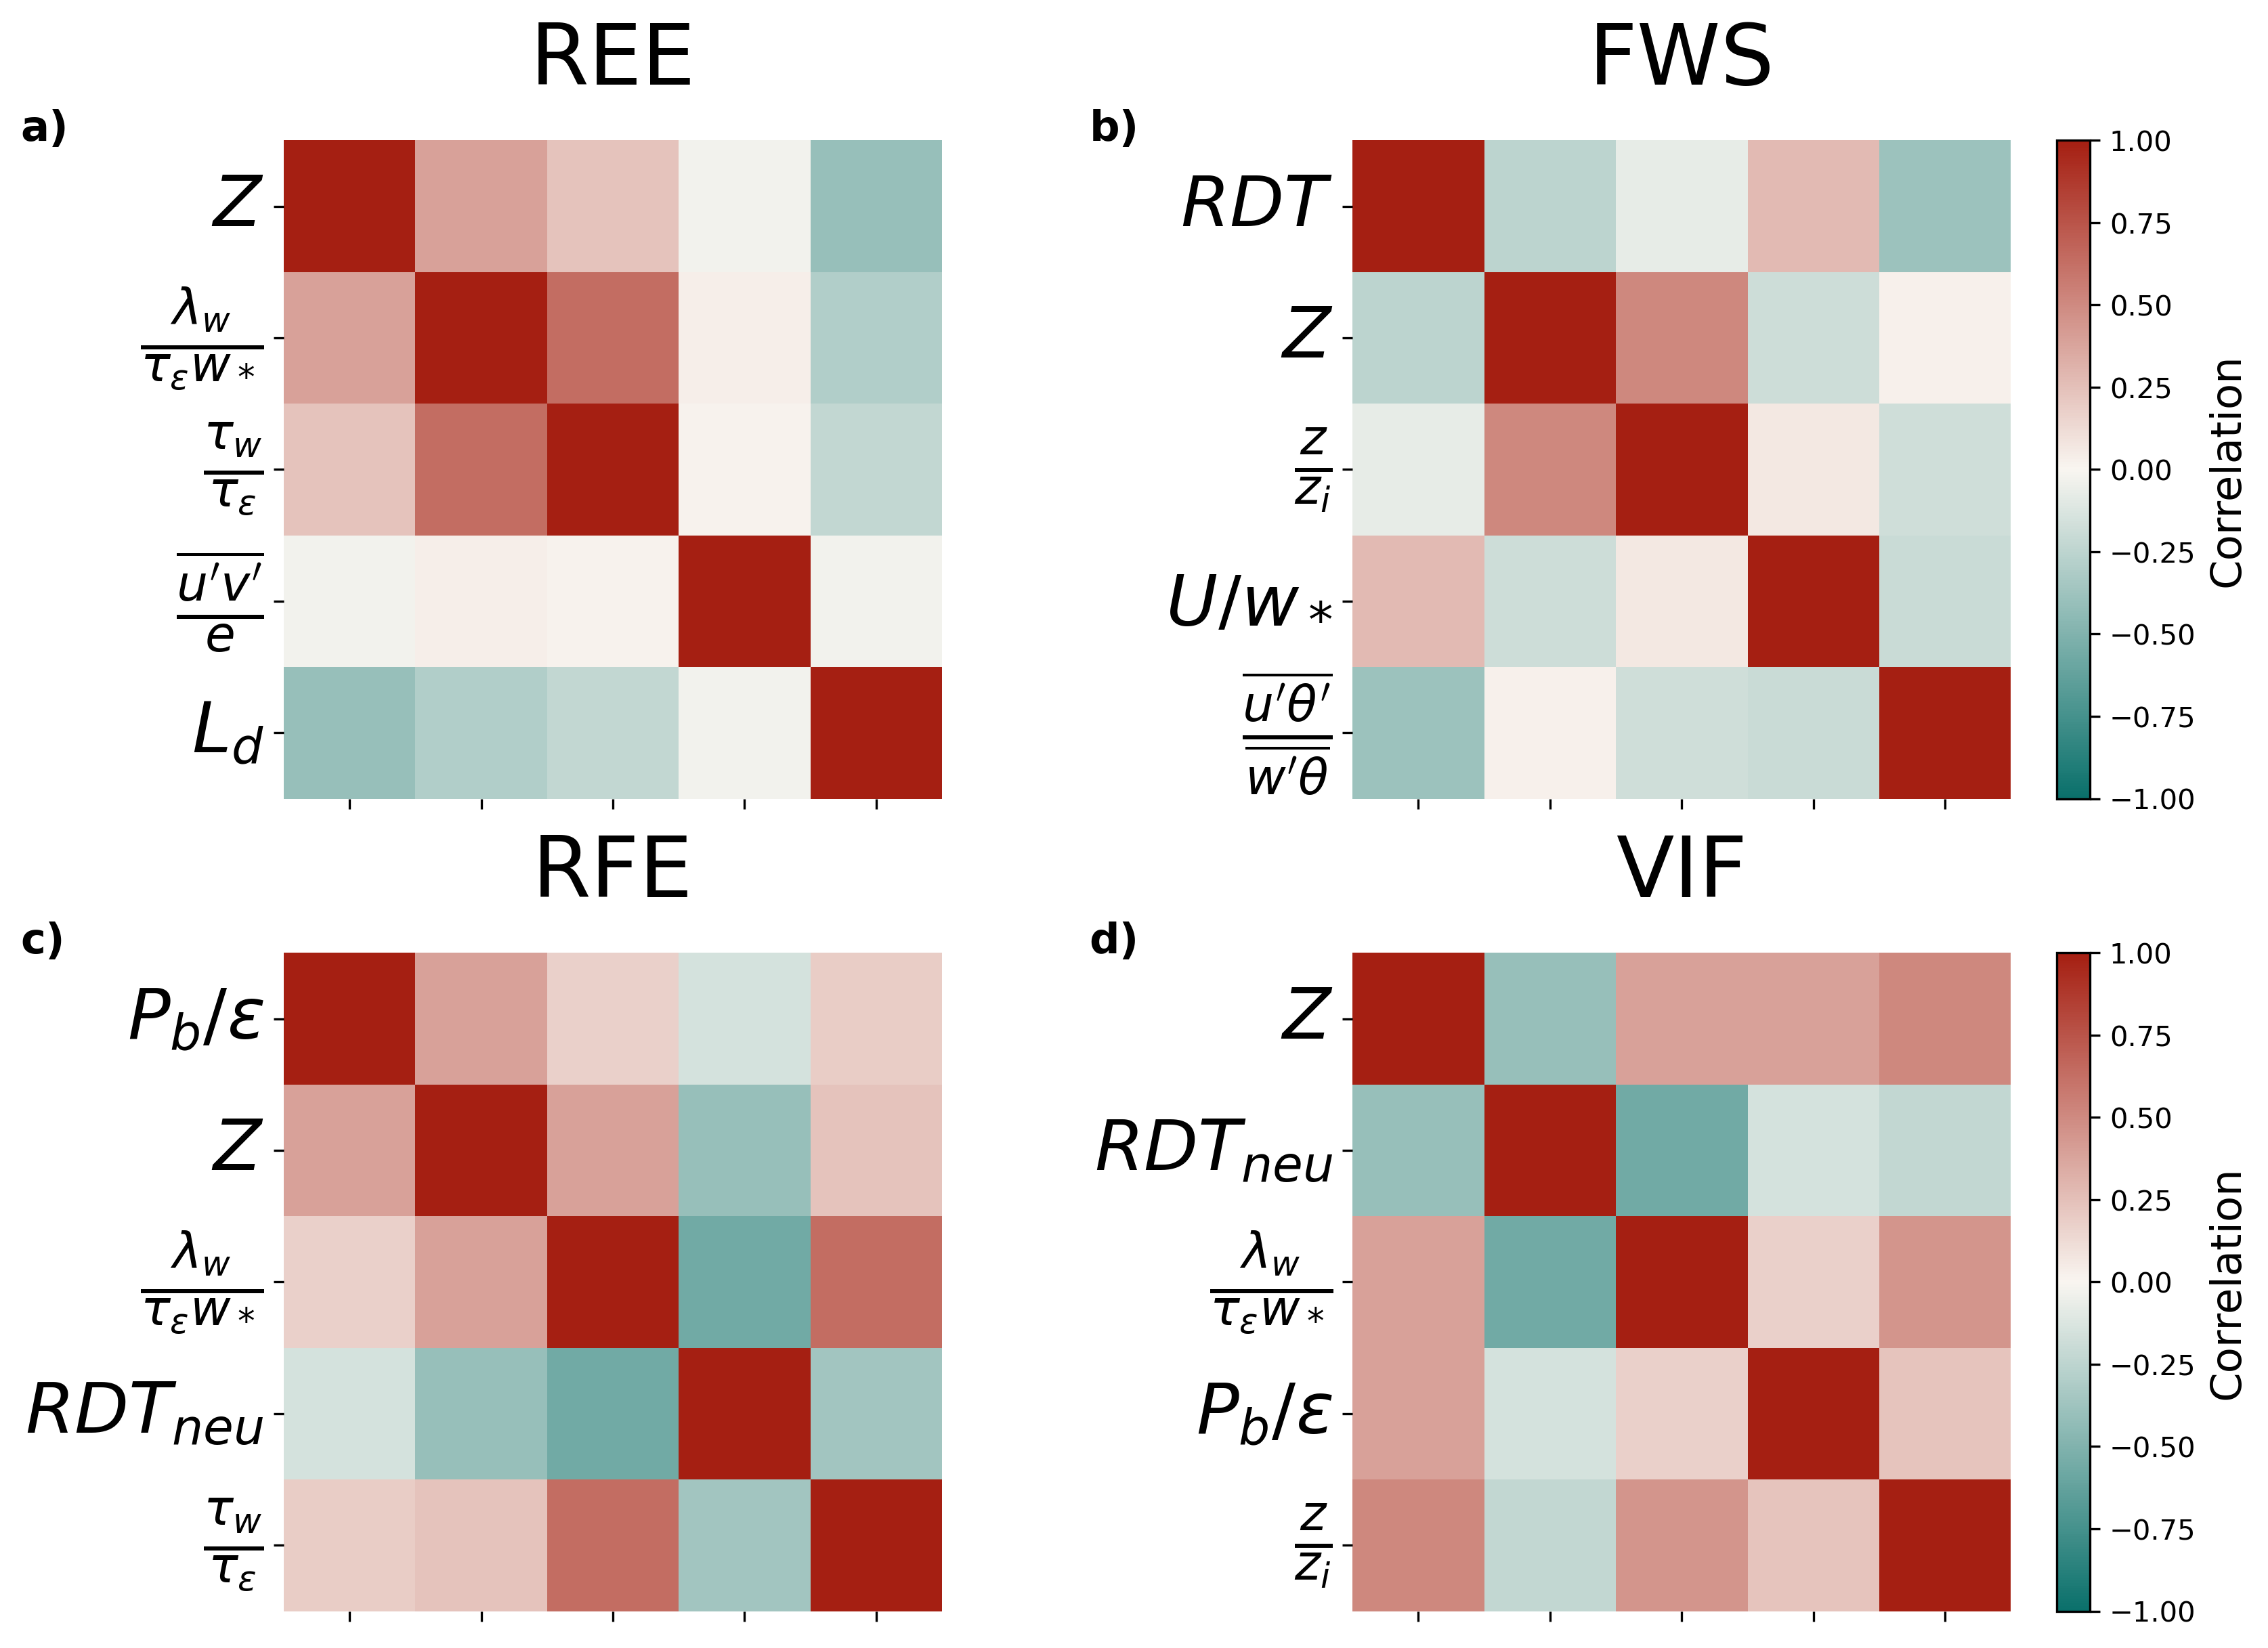

In [43]:
# correlation
correlations_ree = X_train[ree_feat[:5]].corr()
correlations_fws = X_train[fws_feat[:5]].corr()
correlations_rfe = X_train[rfe_feat[:5]].corr()
correlations_vif = X_train[vif_feat[:5]].corr()



# rename for shortness
correlations_ree = correlations_ree.rename(columns=labels_dict, index = labels_dict)
correlations_fws = correlations_fws.rename(columns=labels_dict, index = labels_dict)
correlations_rfe = correlations_rfe.rename(columns=labels_dict, index = labels_dict)
correlations_vif = correlations_vif.rename(columns=labels_dict, index = labels_dict)


# plot
fig, axs = plt.subplots(2,2, figsize=(11,8), constrained_layout=True)
axs=np.hstack(axs)

axs[0].set_aspect(1)
axs[0].set_title("REE", fontsize=30, pad=20)
axs[1].set_aspect(1)
axs[1].set_title("FWS", fontsize=30, pad=20)
axs[2].set_aspect(1)
axs[2].set_title("RFE", fontsize=30, pad=20)
axs[3].set_aspect(1)
axs[3].set_title("VIF", fontsize=30, pad=20)

sns.heatmap(correlations_ree, cmap=cmap, ax=axs[0], vmin=-1, vmax=1,cbar=False)
sns.heatmap(correlations_fws, cmap=cmap, ax=axs[1], vmin=-1, vmax=1,cbar=False)
sns.heatmap(correlations_rfe, cmap=cmap, ax=axs[2], vmin=-1, vmax=1,cbar=False)
sns.heatmap(correlations_vif, cmap=cmap, ax=axs[3], vmin=-1, vmax=1,cbar=False)


for ax in axs:
    for item in (ax.get_yticklabels()):
        item.set_fontsize(25)
        item.set_rotation(0)
    ax.set_xticklabels([])


# add colorbar
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
for ax in axs[1:4:2]:
    color_bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax)
    color_bar.set_label('Correlation', fontsize=15)

# panel letters
for ax, label in zip(np.hstack(axs), ['a)','b)','c)','d)']):
    ax.text(-2,0,label, fontsize=15, weight='bold')

In [55]:
scores=[0.89,0.90,0.89,0.91]

In [59]:
correlations_ree.to_csv('corr_ree_flat.csv')
correlations_fws.to_csv('corr_fws_flat.csv')
correlations_rfe.to_csv('corr_rfe_flat.csv')
correlations_vif.to_csv('corr_vif_flat.csv')